# Evaluation notebook 2
## proposed to observe the all model's performance in a directory

## Contents:
- Notebook configuration
- Load validataion data
- Model evaluation
    - Test main model
    - Test imbalance sampler
    - Test CE loss
    - Test WCE loss
    - Test Focal loss
    - Test activation function
    - Test batch size

In [1]:
import os, sys
import tqdm
import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.ops import sigmoid_focal_loss
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torcheval.metrics.functional import multiclass_f1_score
from sklearn.metrics import cohen_kappa_score, f1_score, jaccard_score, roc_auc_score, accuracy_score, auc

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, RocCurveDisplay, confusion_matrix, precision_recall_curve
from itertools import cycle

from model import *
from utils.evaluation import *
from APTOS_dataset import APTOS_dataset

## Notebook configuration

In [2]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
# plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelpad']='2'
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.scatterpoints'] = 1
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['lines.markersize'] = 5

## Load data

In [3]:
img_dir = r'D:\Aj_Aof_Work\OCT_Disease\DATASET\APTOS2019_V2\images'
val_label_dir = r'D:\Aj_Aof_Work\OCT_Disease\DATASET\APTOS2019_V2\labels\val.csv'
# transforms_val = v2.Compose([
#                     v2.ToTensor(),
#                     v2.RandomHorizontalFlip(),
#                     v2.RandomAutocontrast(),
#                     v2.RandomRotation(degrees=(0, 180)),
#                     # v2.Normalize([0.41333666, 0.22077196, 0.0735625], 
#                     #             [0.23908101, 0.13196332, 0.04935341]), 
#                     v2.Resize((256, 256)),
#                     ])

transforms_val = v2.Compose([
                    v2.ToTensor(),
                    v2.Normalize([0.41333666, 0.22077196, 0.0735625], 
                                [0.23908101, 0.13196332, 0.04935341]), 
                    v2.Resize((256, 256)),
                    ])

dataset = APTOS_dataset(img_dir, val_label_dir, transform=transforms_val, balancing=False)
val_loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=6)

device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

In [26]:
# num_img = 10
# num_col = 5
# num_row = num_img // num_col + 1 if num_img % num_col >= 1 else num_img // num_col

# plt.figure(figsize=(4 * num_col, 4 *num_row))

# for i in range(10):
#     img = dataset[i]['image']
#     a_img = img.permute(1, 2, 0).numpy()
#     plt.subplot(num_row, num_col, i+1)
#     plt.imshow(a_img)
# plt.tight_layout()

## Model evaluation

### Test main model

In [3]:
img_dir = r'D:\Aj_Aof_Work\OCT_Disease\DATASET\APTOS2019_V2\images'
test_label_dir = r'D:\Aj_Aof_Work\OCT_Disease\DATASET\APTOS2019_V2\labels\test.csv'

transforms_test = v2.Compose([
                    v2.ToTensor(),
                    v2.Normalize([0.41333666, 0.22077196, 0.0735625], 
                                [0.23908101, 0.13196332, 0.04935341]), 
                    v2.Resize((256, 256))])

dataset = APTOS_dataset(img_dir, test_label_dir, transform=transforms_test, balancing=False)
test_loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=6)

device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

In [4]:
model_stocks = Call_Model(r'D:\Aj_Aof_Work\OCT_Disease\Grading\Training_results')
# model_stocks = Call_Model(r'D:\Aj_Aof_Work\OCT_Disease\Grading\Training_result_vary_batch')

model_stocks.model_list

{0: '.vs',
 1: 'densenet161_CEloss_v1',
 2: 'densenet161_Floss_v1',
 3: 'densenet161_Imsampler_CEloss_QOloss__v1',
 4: 'densenet161_Imsampler_CEloss_v1',
 5: 'densenet161_Imsampler_Floss_v1',
 6: 'inception_v3_CEloss_v1',
 7: 'inception_v3_Floss_v1',
 8: 'inception_v3_Imsampler_CEloss_v1',
 9: 'inception_v3_Imsampler_Floss_v1',
 10: 'resnet50_CEloss_v1',
 11: 'resnet50_Floss_v1',
 12: 'resnet50_Imsampler_CEloss_v1',
 13: 'resnet50_Imsampler_Floss_v1',
 14: 'swin_s_CEloss_v1',
 15: 'swin_s_Floss_v1',
 16: 'swin_s_Imsampler_CEloss_QOloss__v1',
 17: 'swin_s_Imsampler_CEloss_v1',
 18: 'swin_s_Imsampler_Floss_v1',
 19: 'vgg19_CEloss_v1',
 20: 'vgg19_Floss_v1',
 21: 'vgg19_Imsampler_CEloss_v1',
 22: 'vgg19_Imsampler_Floss_v1'}

In [5]:
num = 4
actual_lst, pred_lst, prob_lst = model_stocks.test_model(num, test_loader, device, return_prob=True)
kappa = cohen_kappa_score(actual_lst, pred_lst, weights='quadratic')
f1_macro = f1_score(actual_lst, pred_lst, average='macro')
f1_micro = f1_score(actual_lst, pred_lst, average='micro')
roc_macro = roc_auc_score(actual_lst, prob_lst, average='macro', multi_class='ovr')
roc_micro = roc_auc_score(actual_lst, prob_lst, average='micro', multi_class='ovr')
acc = accuracy_score(actual_lst, pred_lst)

100%|██████████| 23/23 [00:22<00:00,  1.02it/s]


In [6]:
""" Balance test data """
print('Model name:', model_stocks.model_list[num])
print(f'{acc=}, {f1_micro=}, {roc_micro=}, {f1_macro=}, {roc_macro=}, {kappa=}')

Model name: densenet161_Imsampler_CEloss_v1
acc=0.7893296853625171, f1_micro=0.7893296853625171, roc_micro=0.9591465320261022, f1_macro=0.6451298891469749, roc_macro=0.9291801863734894, kappa=0.8690670977142537


In [17]:
print('Model name:', model_stocks.model_list[num])
print(f'{acc=}, {f1_micro=}, {roc_micro=}, {f1_macro=}, {roc_macro=}, {kappa=}')

Model name: densenet161_Imsampler_CEloss_v1
acc=0.7893296853625171, f1_micro=0.7893296853625171, roc_micro=0.9591465320261022, f1_macro=0.6451298891469749, roc_macro=0.9291801863734894, kappa=0.8690670977142537


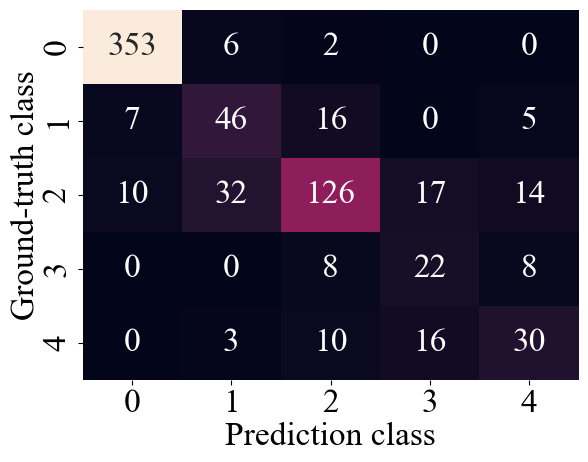

In [18]:
plt.rcParams['font.size'] = 24
cm = confusion_matrix(actual_lst, pred_lst)
sns.heatmap(cm, annot=True, fmt='.0f', cbar=False)
plt.ylabel('Ground-truth class')
plt.xlabel('Prediction class')
plt.show()

In [20]:
num_class = 3
a = prob_lst[:, num_class]
b = (actual_lst == num_class).astype(int)
fpr_lst, tpr_lst = [], []
precision_lst, recall_lst = [], []
for a_thersh in np.linspace(0, 1, 100):
    aa = (a >= a_thersh).astype(int)
    cm = confusion_matrix(b, aa)
    (tn, fp, fn, tp) = cm.ravel()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    fpr_lst.append(fpr)
    tpr_lst.append(tpr)
    precision = tp / (tp + fp)
    if np.isnan(precision):
        precision = 1
    recall = tp / (tp + fn)
    precision_lst.append(precision)
    recall_lst.append(recall)

(-0.2, 1.2)

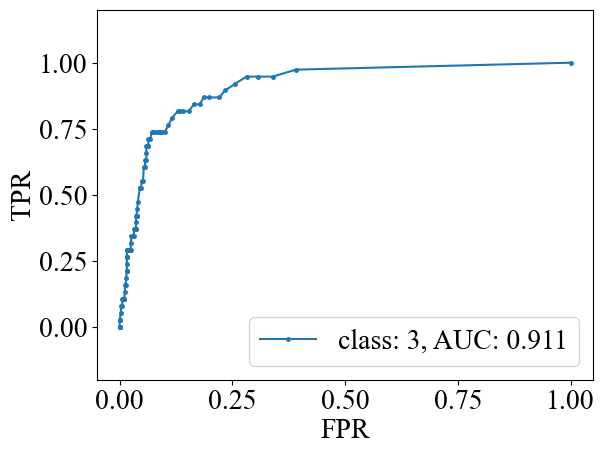

In [21]:
plt.plot(fpr_lst, tpr_lst, '.-', label=f'class: {num_class}, AUC: {np.round(auc(fpr_lst, tpr_lst), 3)}')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.ylim([-0.2, 1.2])

(-0.2, 1.2)

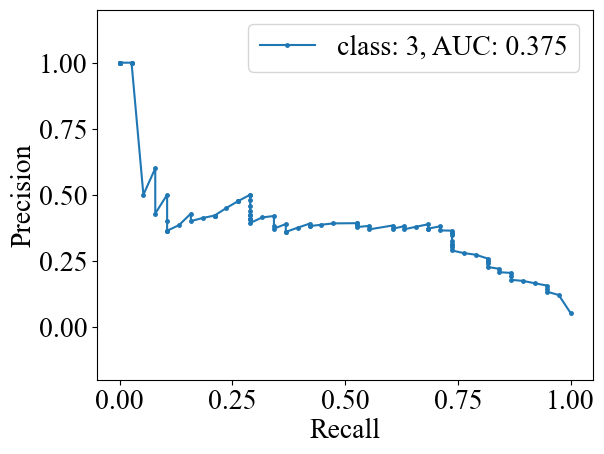

In [22]:
plt.plot(recall_lst, precision_lst, '.-', label=f'class: {num_class}, AUC: {np.round(auc(recall_lst, precision_lst), 3)}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.ylim([-0.2, 1.2])

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       361
           1       0.53      0.62      0.57        74
           2       0.78      0.63      0.70       199
           3       0.40      0.58      0.47        38
           4       0.53      0.51      0.52        59

    accuracy                           0.79       731
   macro avg       0.64      0.66      0.65       731
weighted avg       0.80      0.79      0.79       731



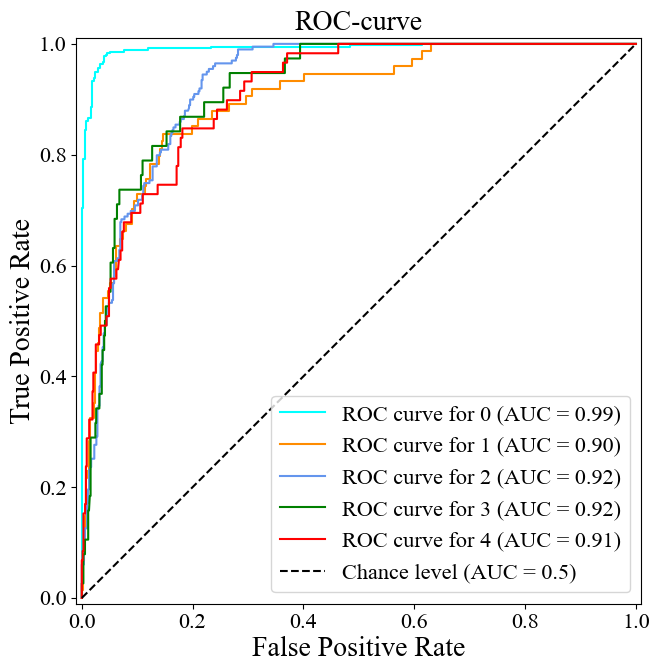

In [47]:
from sklearn.metrics import classification_report, RocCurveDisplay
from itertools import cycle

print(classification_report(actual_lst, pred_lst))

n_classes = 5
target_names = [0, 1, 2, 3, 4]

plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(figsize=(7, 7))

colors = cycle(["aqua", "darkorange", "cornflowerblue", 'green', 'red'])
for class_id, color in zip(range(n_classes), colors):
    # print(class_id)
    RocCurveDisplay.from_predictions(
        (actual_lst == class_id).astype(int),
        prob_lst[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
        plot_chance_level=(class_id == 4),
    )

# _ = ax.set(
#     xlabel="False Positive Rate",
#     ylabel="True Positive Rate",
#     title="ROC-curve"
# )
_ = ax.set_xlabel("False Positive Rate", fontsize=20)
_ = ax.set_ylabel("True Positive Rate", fontsize=20)
_ = ax.set_title("ROC-curve", fontsize=20)
plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       361
           1       0.53      0.62      0.57        74
           2       0.78      0.63      0.70       199
           3       0.40      0.58      0.47        38
           4       0.53      0.51      0.52        59

    accuracy                           0.79       731
   macro avg       0.64      0.66      0.65       731
weighted avg       0.80      0.79      0.79       731



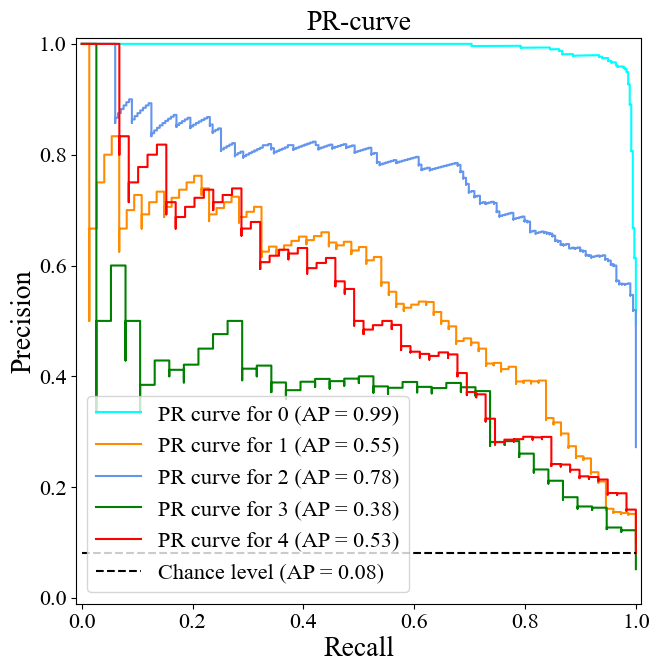

In [48]:
from sklearn.metrics import classification_report, RocCurveDisplay, PrecisionRecallDisplay
from itertools import cycle

print(classification_report(actual_lst, pred_lst))

n_classes = 5
target_names = [0, 1, 2, 3, 4]

plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(figsize=(7, 7))

colors = cycle(["aqua", "darkorange", "cornflowerblue", 'green', 'red'])
for class_id, color in zip(range(n_classes), colors):
    # print(class_id)
    PrecisionRecallDisplay.from_predictions(
        (actual_lst == class_id).astype(int),
        prob_lst[:, class_id], 
        name=f"PR curve for {target_names[class_id]}", 
        color=color,
        ax=ax,
        plot_chance_level=(class_id == 4)
    )

# _ = ax.set(
#     xlabel="Recall",
#     ylabel="Precision",
#     title="PR-curve",
# )
_ = ax.set_xlabel("Recall", fontsize=20)
_ = ax.set_ylabel("Precision", fontsize=20)
_ = ax.set_title("PR-curve", fontsize=20)
# plt.legend(bbox_to_anchor=(1.04, 1))
plt.tight_layout()
plt.show()

### Test CE loss

In [27]:
model_stocks = Call_Model(r'D:\Aj_Aof_Work\OCT_Disease\Grading\Training_results_loss_fn\CE')
# model_stocks = Call_Model(r'D:\Aj_Aof_Work\OCT_Disease\Grading\Training_result_vary_batch')

model_stocks.model_list

{0: 'densenet161_Imsampler_CEloss_Batch16_v1',
 1: 'densenet161_Imsampler_CEloss_Batch16_v2',
 2: 'densenet161_Imsampler_CEloss_Batch32_v1',
 3: 'densenet161_Imsampler_CEloss_Batch32_v2',
 4: 'densenet161_Imsampler_CEloss_Batch4_v1',
 5: 'densenet161_Imsampler_CEloss_Batch4_v2',
 6: 'densenet161_Imsampler_CEloss_Batch64_v1',
 7: 'densenet161_Imsampler_CEloss_Batch8_v1',
 8: 'densenet161_Imsampler_CEloss_Batch8_v2',
 9: 'densenet161_Imsampler_CEloss_Grokking_v1',
 10: 'densenet161_Imsampler_CEloss_Grokking_v2',
 11: 'densenet161_Imsampler_CEloss_Grokking_v3',
 12: 'densenet161_Imsampler_CEloss_Grokking_v4'}

In [28]:
result_df = model_stocks.roughly_evaluation_all_model(val_loader, device)

100%|██████████| 23/23 [00:21<00:00,  1.08it/s]


In [29]:
### Right result
a = result_df[['Name', 'ACC', 'F1 (micro)', 'AUCROC (micro)', 'F1 (macro)', 'AUCROC (macro)', 'QWK']]
for name in ['densenet', 'swin']:
    idx = a['Name'].str.contains(name)
    print('Model name:', name)
    print(a[idx].copy().drop(columns=['Name']).mean())
a

Model name: densenet
ACC               0.798169
F1 (micro)        0.798169
AUCROC (micro)    0.958232
F1 (macro)        0.655617
AUCROC (macro)    0.929069
QWK               0.850831
dtype: float64
Model name: swin
ACC              NaN
F1 (micro)       NaN
AUCROC (micro)   NaN
F1 (macro)       NaN
AUCROC (macro)   NaN
QWK              NaN
dtype: float64


,Name,ACC,F1 (micro),AUCROC (micro),F1 (macro),AUCROC (macro),QWK
0,densenet161_Imsampler_CEloss_Batch16_v1,0.783858,0.783858,0.956969,0.637696,0.928864,0.845677
1,densenet161_Imsampler_CEloss_Batch16_v2,0.800274,0.800274,0.957906,0.658935,0.929788,0.841179
2,densenet161_Imsampler_CEloss_Batch32_v1,0.792066,0.792066,0.960441,0.636113,0.928674,0.831019
3,densenet161_Imsampler_CEloss_Batch32_v2,0.792066,0.792066,0.959169,0.652755,0.931520,0.851009
4,densenet161_Imsampler_CEloss_Batch4_v1,0.803010,0.803010,0.956160,0.661649,0.925599,0.857337
5,densenet161_Imsampler_CEloss_Batch4_v2,0.796170,0.796170,0.959251,0.657050,0.930116,0.858066
6,densenet161_Imsampler_CEloss_Batch64_v1,0.808482,0.808482,0.958649,0.666979,0.927779,0.854689
7,densenet161_Imsampler_CEloss_Batch8_v1,0.797538,0.797538,0.957308,0.656200,0.928024,0.846363
8,densenet161_Imsampler_CEloss_Batch8_v2,0.800274,0.800274,0.959682,0.662425,0.934191,0.855158
9,densenet161_Imsampler_CEloss_Grokking_v1,0.804378,0.804378,0.957294,0.663784,0.927252,0.852293


### Test WCEloss

In [11]:
model_stocks = Call_Model(r'D:\Aj_Aof_Work\OCT_Disease\Grading\Training_results_loss_fn\WCE_loss')
# model_stocks = Call_Model(r'D:\Aj_Aof_Work\OCT_Disease\Grading\Training_result_vary_batch')

model_stocks.model_list

{0: 'densenet161_Imsampler_WCEloss_v1',
 1: 'densenet161_Imsampler_WCEloss_v2',
 2: 'swin_s_Imsampler_WCEloss_v1'}

In [12]:
result_df = model_stocks.roughly_evaluation_all_model(val_loader, device)

100%|██████████| 23/23 [00:21<00:00,  1.05it/s]


In [13]:
a = result_df[['Name', 'ACC', 'F1 (micro)', 'AUCROC (micro)', 'F1 (macro)', 'AUCROC (macro)', 'QWK']]
for name in ['densenet', 'swin']:
    idx = a['Name'].str.contains(name)
    print('Model name:', name)
    print(a[idx].copy().drop(columns=['Name']).mean())
a

Model name: densenet
ACC               0.766074
F1 (micro)        0.766074
AUCROC (micro)    0.947256
F1 (macro)        0.620905
AUCROC (macro)    0.917821
QWK               0.830975
dtype: float64
Model name: swin
ACC               0.790698
F1 (micro)        0.790698
AUCROC (micro)    0.956608
F1 (macro)        0.629329
AUCROC (macro)    0.925425
QWK               0.850973
dtype: float64


,Name,ACC,F1 (micro),AUCROC (micro),F1 (macro),AUCROC (macro),QWK
0,densenet161_Imsampler_WCEloss_v1,0.778386,0.778386,0.950234,0.633573,0.921130,0.841602
1,densenet161_Imsampler_WCEloss_v2,0.753762,0.753762,0.944278,0.608237,0.914511,0.820349
2,swin_s_Imsampler_WCEloss_v1,0.790698,0.790698,0.956608,0.629329,0.925425,0.850973


### Test Focal loss

In [6]:
model_stocks = Call_Model(r'D:\Aj_Aof_Work\OCT_Disease\Grading\Training_results_loss_fn\Focal_loss')
# model_stocks = Call_Model(r'D:\Aj_Aof_Work\OCT_Disease\Grading\Training_result_vary_batch')

model_stocks.model_list

{0: 'densenet161_Imsampler_Floss1_v0',
 1: 'densenet161_Imsampler_Floss2_v1',
 2: 'densenet161_Imsampler_Floss3_v2',
 3: 'densenet161_Imsampler_Floss4_v3',
 4: 'densenet161_Imsampler_Floss5_v4',
 5: 'swin_s_Imsampler_Floss1_v0',
 6: 'swin_s_Imsampler_Floss2_v1',
 7: 'swin_s_Imsampler_Floss3_v2'}

In [7]:
result_df = model_stocks.roughly_evaluation_all_model(val_loader, device)

100%|██████████| 23/23 [00:20<00:00,  1.12it/s]


In [8]:
### Right result
a = result_df[['Name', 'ACC', 'F1 (micro)', 'AUCROC (micro)', 'F1 (macro)', 'AUCROC (macro)', 'QWK']]
for name in ['densenet', 'swin']:
    idx = a['Name'].str.contains(name)
    print('Model name:', name)
    print(a[idx].copy().drop(columns=['Name']).mean())
a

Model name: densenet
ACC               0.793434
F1 (micro)        0.793434
AUCROC (micro)    0.957200
F1 (macro)        0.644956
AUCROC (macro)    0.924579
QWK               0.854020
dtype: float64
Model name: swin
ACC               0.797082
F1 (micro)        0.797082
AUCROC (micro)    0.958568
F1 (macro)        0.626591
AUCROC (macro)    0.927831
QWK               0.848069
dtype: float64


,Name,ACC,F1 (micro),AUCROC (micro),F1 (macro),AUCROC (macro),QWK
0,densenet161_Imsampler_Floss1_v0,0.796170,0.796170,0.956376,0.638623,0.923792,0.856852
1,densenet161_Imsampler_Floss2_v1,0.794802,0.794802,0.956364,0.655786,0.925456,0.851046
2,densenet161_Imsampler_Floss3_v2,0.792066,0.792066,0.958201,0.634685,0.926351,0.855879
3,densenet161_Imsampler_Floss4_v3,0.794802,0.794802,0.958159,0.654133,0.924386,0.859142
4,densenet161_Imsampler_Floss5_v4,0.789330,0.789330,0.956897,0.641554,0.922911,0.847180
5,swin_s_Imsampler_Floss1_v0,0.803010,0.803010,0.959873,0.642680,0.929711,0.858142
6,swin_s_Imsampler_Floss2_v1,0.808482,0.808482,0.960968,0.637075,0.929945,0.845731
7,swin_s_Imsampler_Floss3_v2,0.779754,0.779754,0.954864,0.600017,0.923836,0.840335


### Test activation function

In [8]:
model_stocks = Call_Model(r'D:\Aj_Aof_Work\OCT_Disease\Grading\Training_results_Balance_data_DenseNet')
# model_stocks = Call_Model(r'D:\Aj_Aof_Work\OCT_Disease\Grading\Training_result_vary_batch')

model_stocks.model_list

{0: 'densenet161_BalanceData_Imsampler_CEloss_GELU_v1',
 1: 'densenet161_BalanceData_Imsampler_CEloss_GELU_v1_combiantion',
 2: 'densenet161_BalanceData_Imsampler_CEloss_GELU_v2',
 3: 'densenet161_BalanceData_Imsampler_CEloss_GELU_v3',
 4: 'densenet161_BalanceData_Imsampler_CEloss_SELU_v1',
 5: 'densenet161_BalanceData_Imsampler_CEloss_SELU_v1_combiantion',
 6: 'densenet161_BalanceData_Imsampler_CEloss_SELU_v2',
 7: 'densenet161_BalanceData_Imsampler_CEloss_SELU_v3',
 8: 'densenet161_BalanceData_Imsampler_CEloss_v1_baseline',
 9: 'densenet161_BalanceData_Imsampler_CEloss_v1_larger',
 10: 'densenet161_BalanceData_Imsampler_CEloss_v2_baseline',
 11: 'densenet161_BalanceData_Imsampler_CEloss_v2_larger',
 12: 'densenet161_BalanceData_Imsampler_CEloss_v3_baseline',
 13: 'densenet161_BalanceData_Imsampler_CEloss_v3_larger'}

In [9]:
result_df = model_stocks.roughly_evaluation_all_model(val_loader, device)

100%|██████████| 23/23 [00:35<00:00,  1.56s/it]


In [10]:
a = result_df[['Name', 'ACC', 'F1 (micro)', 'AUCROC (micro)', 'F1 (macro)', 'AUCROC (macro)', 'QWK']]
for name in ['GELU_v', 'SELU_v', 'large', 'baseline']:
    idx = a['Name'].str.contains(name)
    print('Model name:', name)
    print(a[idx].copy().drop(columns=['Name']).mean())
a

Model name: GELU_v
ACC               0.783174
F1 (micro)        0.783174
AUCROC (micro)    0.951728
F1 (macro)        0.667471
AUCROC (macro)    0.943242
QWK               0.847259
dtype: float64
Model name: SELU_v
ACC               0.792408
F1 (micro)        0.792408
AUCROC (micro)    0.954482
F1 (macro)        0.685286
AUCROC (macro)    0.944762
QWK               0.848161
dtype: float64
Model name: large
ACC               0.792522
F1 (micro)        0.792522
AUCROC (micro)    0.956081
F1 (macro)        0.682890
AUCROC (macro)    0.944603
QWK               0.860770
dtype: float64
Model name: baseline
ACC               0.810306
F1 (micro)        0.810306
AUCROC (micro)    0.962076
F1 (macro)        0.712779
AUCROC (macro)    0.953346
QWK               0.871099
dtype: float64


,Name,ACC,F1 (micro),AUCROC (micro),F1 (macro),AUCROC (macro),QWK
0,densenet161_BalanceData_Imsampler_CEloss_GELU_v1,0.805746,0.805746,0.954003,0.702838,0.945026,0.859050
1,densenet161_BalanceData_Imsampler_CEloss_GELU_...,0.770178,0.770178,0.947915,0.646775,0.939925,0.840984
2,densenet161_BalanceData_Imsampler_CEloss_GELU_v2,0.770178,0.770178,0.947915,0.646775,0.939925,0.840984
3,densenet161_BalanceData_Imsampler_CEloss_GELU_v3,0.786594,0.786594,0.957079,0.673496,0.948092,0.848018
4,densenet161_BalanceData_Imsampler_CEloss_SELU_v1,0.763338,0.763338,0.944418,0.623507,0.929641,0.806426
5,densenet161_BalanceData_Imsampler_CEloss_SELU_...,0.785226,0.785226,0.956091,0.690840,0.949829,0.850056
6,densenet161_BalanceData_Imsampler_CEloss_SELU_v2,0.815321,0.815321,0.959857,0.723891,0.951231,0.871613
7,densenet161_BalanceData_Imsampler_CEloss_SELU_v3,0.805746,0.805746,0.957564,0.702904,0.948348,0.864550
8,densenet161_BalanceData_Imsampler_CEloss_v1_ba...,0.804378,0.804378,0.961285,0.704849,0.952684,0.867716
9,densenet161_BalanceData_Imsampler_CEloss_v1_la...,0.785226,0.785226,0.952599,0.673819,0.939600,0.854265


### Test batch size

In [5]:
model_stocks = Call_Model(r'D:\Aj_Aof_Work\OCT_Disease\Grading\Training_result_vary_batch_V2')
# model_stocks = Call_Model(r'D:\Aj_Aof_Work\OCT_Disease\Grading\Training_result_vary_batch')

model_stocks.model_list

{0: 'densenet161_Imsampler_CEloss_Batch128_v1',
 1: 'densenet161_Imsampler_CEloss_Batch128_v2',
 2: 'densenet161_Imsampler_CEloss_Batch16_v1',
 3: 'densenet161_Imsampler_CEloss_Batch16_v2',
 4: 'densenet161_Imsampler_CEloss_Batch32_v1',
 5: 'densenet161_Imsampler_CEloss_Batch32_v2',
 6: 'densenet161_Imsampler_CEloss_Batch4_v1',
 7: 'densenet161_Imsampler_CEloss_Batch4_v2',
 8: 'densenet161_Imsampler_CEloss_Batch64_v1',
 9: 'densenet161_Imsampler_CEloss_Batch64_v2',
 10: 'densenet161_Imsampler_CEloss_Batch8_v1',
 11: 'densenet161_Imsampler_CEloss_Batch8_v2'}

In [6]:
result_df = model_stocks.roughly_evaluation_all_model(val_loader, device)

100%|██████████| 23/23 [00:20<00:00,  1.11it/s]


In [7]:
a = result_df[['Name', 'ACC', 'F1 (micro)', 'AUCROC (micro)', 'F1 (macro)', 'AUCROC (macro)', 'QWK']]
for name in ['Batch4', 'Batch8', 'Batch16', 'Batch32', 'Batch64', 'Batch128']:
    idx = a['Name'].str.contains(name)
    print('Model name:', name)
    print(a[idx].copy().drop(columns=['Name']).mean())
a

Model name: Batch4
ACC               0.787278
F1 (micro)        0.787278
AUCROC (micro)    0.955018
F1 (macro)        0.637376
AUCROC (macro)    0.924932
QWK               0.834939
dtype: float64
Model name: Batch8
ACC               0.793434
F1 (micro)        0.793434
AUCROC (micro)    0.956683
F1 (macro)        0.651333
AUCROC (macro)    0.928299
QWK               0.847142
dtype: float64
Model name: Batch16
ACC               0.792066
F1 (micro)        0.792066
AUCROC (micro)    0.958204
F1 (macro)        0.647373
AUCROC (macro)    0.929233
QWK               0.846898
dtype: float64
Model name: Batch32
ACC               0.803694
F1 (micro)        0.803694
AUCROC (micro)    0.960164
F1 (macro)        0.660662
AUCROC (macro)    0.930027
QWK               0.853654
dtype: float64
Model name: Batch64
ACC               0.800274
F1 (micro)        0.800274
AUCROC (micro)    0.958510
F1 (macro)        0.654839
AUCROC (macro)    0.929116
QWK               0.844252
dtype: float64
Model name: Batch

,Name,ACC,F1 (micro),AUCROC (micro),F1 (macro),AUCROC (macro),QWK
0,densenet161_Imsampler_CEloss_Batch128_v1,0.798906,0.798906,0.959787,0.662530,0.931674,0.848431
1,densenet161_Imsampler_CEloss_Batch128_v2,0.798906,0.798906,0.958341,0.655274,0.929851,0.847849
2,densenet161_Imsampler_CEloss_Batch16_v1,0.786594,0.786594,0.958936,0.638244,0.929321,0.852785
3,densenet161_Imsampler_CEloss_Batch16_v2,0.797538,0.797538,0.957472,0.656502,0.929145,0.841012
4,densenet161_Imsampler_CEloss_Batch32_v1,0.812585,0.812585,0.960762,0.662897,0.927976,0.859805
5,densenet161_Imsampler_CEloss_Batch32_v2,0.794802,0.794802,0.959566,0.658427,0.932078,0.847503
6,densenet161_Imsampler_CEloss_Batch4_v1,0.786594,0.786594,0.953242,0.638720,0.923095,0.832795
7,densenet161_Imsampler_CEloss_Batch4_v2,0.787962,0.787962,0.956795,0.636032,0.926769,0.837084
8,densenet161_Imsampler_CEloss_Batch64_v1,0.801642,0.801642,0.958198,0.661773,0.929598,0.851814
9,densenet161_Imsampler_CEloss_Batch64_v2,0.798906,0.798906,0.958821,0.647905,0.928634,0.836689
